In [74]:
## importing libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set_style('darkgrid')

In [2]:
## reading in dataset
# other way - pyodbc

df = pd.read_csv('breach-prediction-dataset_MW_pandas_2.csv')

df.head()

,date,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,...,vms_net_30d,cpu_util_perc,mem_util_perc,breach,breach_reason,breach_date,total_days_before_breach,days_until_breach,90d_breach,days_since_breach
0,10/13/2017,10,13,1,10,4,2,3,2,13,...,-21.0,0.3570,0.5736,0,NaN,1511222400,498,39,1,NaN
1,10/13/2017,10,13,1,10,11,6,3,2,16,...,23.0,0.0691,0.5143,0,NaN,1509753600,173,22,1,NaN
2,10/13/2017,10,13,1,10,11,6,3,2,14,...,4.0,0.1695,0.5159,0,NaN,1513987200,530,71,1,NaN
3,10/13/2017,10,13,2,2,4,2,5,2,21,...,14.0,0.0376,0.1436,0,NaN,1526860800,641,220,0,NaN
4,10/13/2017,10,13,2,2,11,6,5,2,23,...,7.0,0.0284,0.2973,0,NaN,1520985600,572,152,0,NaN


In [3]:
# checking data frame shape - how many rows and columns (number of features plus the predicted variable)
df.shape

(4978, 46)

In [6]:
df.columns

Index([u'date', u'month', u'day', u'region', u'datacenter', u'service',
       u'pipeline_code', u'pod', u'pod_vers', u'cluster', u'cluster_age',
       u'avg_vm_age', u'vm_count_ccr', u'vc_vm_count', u'opthresh',
       u'otis_opstat', u'vra_opstat', u'ccr_opstat', u'storage_growth_rate30d',
       u'esx_hosts', u'cpu_cores', u'cpu_threads', u'memory_gb', u'total_vms',
       u'expired_vms', u'vms_on', u'vms_off', u'vm_density', u'vms_added_1d',
       u'vms_removed_1d', u'vms_net_1d', u'vms_added_7d', u'vms_removed_7d',
       u'vms_net_7d', u'vms_added_30d', u'vms_removed_30d', u'vms_net_30d',
       u'cpu_util_perc', u'mem_util_perc', u'breach', u'breach_reason',
       u'breach_date', u'total_days_before_breach', u'days_until_breach',
       u'90d_breach', u'days_since_breach'],
      dtype='object')

In [7]:
df.dtypes

date                         object
month                         int64
day                           int64
region                        int64
datacenter                    int64
service                       int64
pipeline_code                 int64
pod                           int64
pod_vers                      int64
cluster                       int64
cluster_age                   int64
avg_vm_age                    int64
vm_count_ccr                  int64
vc_vm_count                   int64
opthresh                    float64
otis_opstat                 float64
vra_opstat                  float64
ccr_opstat                  float64
storage_growth_rate30d      float64
esx_hosts                   float64
cpu_cores                   float64
cpu_threads                 float64
memory_gb                   float64
total_vms                   float64
expired_vms                 float64
vms_on                      float64
vms_off                     float64
vm_density                  

In [8]:
# checking our reposnse variable 
# classes aren't balanced
df["90d_breach"].value_counts()

1    3092
0    1886
Name: 90d_breach, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 46 columns):
date                        4978 non-null object
month                       4978 non-null int64
day                         4978 non-null int64
region                      4978 non-null int64
datacenter                  4978 non-null int64
service                     4978 non-null int64
pipeline_code               4978 non-null int64
pod                         4978 non-null int64
pod_vers                    4978 non-null int64
cluster                     4978 non-null int64
cluster_age                 4978 non-null int64
avg_vm_age                  4978 non-null int64
vm_count_ccr                4978 non-null int64
vc_vm_count                 4978 non-null int64
opthresh                    4978 non-null float64
otis_opstat                 4341 non-null float64
vra_opstat                  0 non-null float64
ccr_opstat                  2245 non-null float64
storage_growth_rate30d 

In [10]:
df.describe()

,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,cluster_age,...,vms_net_30d,cpu_util_perc,mem_util_perc,breach,breach_reason,breach_date,total_days_before_breach,days_until_breach,90d_breach,days_since_breach
count,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,...,4343.000000,4978.000000,4978.000000,4978.0,0.0,4.978000e+03,4978.000000,4978.000000,4978.000000,0.0
mean,6.027320,15.216754,3.572117,5.901366,6.697067,4.271796,17.210928,2.449578,102.066894,258.551627,...,33.089109,0.135602,0.392515,0.0,NaN,1.523468e+09,335.866412,77.314785,0.621133,NaN
std,4.317756,8.442969,0.865081,3.209094,3.713174,2.901686,7.803295,0.590910,54.012692,168.599709,...,67.286158,0.114960,0.196692,0.0,NaN,4.796515e+06,169.099551,54.321574,0.485154,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,10.000000,...,-130.000000,0.000000,0.000000,0.0,NaN,1.507939e+09,64.000000,1.000000,0.000000,NaN
25%,2.000000,8.000000,4.000000,3.000000,4.000000,2.000000,12.000000,2.000000,54.000000,119.000000,...,0.000000,0.051100,0.252850,0.0,NaN,1.520986e+09,205.000000,31.000000,0.000000,NaN
50%,4.000000,15.000000,4.000000,6.000000,4.000000,2.000000,17.000000,3.000000,99.000000,205.000000,...,2.000000,0.115150,0.438850,0.0,NaN,1.523750e+09,291.000000,68.000000,1.000000,NaN
75%,11.000000,22.000000,4.000000,8.000000,11.000000,6.000000,23.000000,3.000000,141.000000,401.000000,...,39.000000,0.185275,0.570000,0.0,NaN,1.526861e+09,486.000000,116.000000,1.000000,NaN
max,12.000000,31.000000,4.000000,11.000000,13.000000,10.000000,29.000000,3.000000,182.000000,719.000000,...,701.000000,0.645000,0.650000,0.0,NaN,1.531181e+09,721.000000,247.000000,1.000000,NaN


In [11]:
df.region.value_counts()

4    3877
2     581
3     296
1     224
Name: region, dtype: int64

In [12]:
df.datacenter.max()

11

In [13]:
df.cluster.value_counts()

180    217
137    193
21     192
113    191
138    186
86     184
175    181
83     181
104    170
89     160
181    159
38     152
134    151
97     150
30     143
99     143
141    138
23     131
2      125
54     121
179    117
28     108
182    107
96     103
27      99
168     98
98      95
158     88
95      84
94      82
75      77
110     72
152     66
53      60
14      57
151     54
26      51
131     50
135     49
178     40
13      28
74      23
91      20
48      15
90      14
16      14
92      13
166     13
125     12
40       1
Name: cluster, dtype: int64

In [14]:
df.cluster.max()

182

In [20]:
##### Coding categorical features

In [21]:
df['month_2'] = df.month.map({1:'Jan', 2:'Feb', 3:'March', 4:'Apr', 5:'May', 6:'June', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11: 'Nov', 12:'Dec'})

In [22]:
df['region_2'] = df.region.map({1:'A', 2:'B', 3:'C', 4:'D'})

In [23]:
df['datacenter_2'] = df.datacenter.map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J', 11: 'K'})

In [24]:
df['service_2'] = df.datacenter.map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J', 11: 'K', 12:'L', 13:'M'})

In [25]:
df['pipeline_code_2'] = df.pipeline_code.map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J'})

In [26]:
df['pod_2'] = df.pod.map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J', 11: 'K', 12:'L', 13:'M',14:'N', 15:'O', 16:'P', 17:'Q', 18:'R', 19:'S', 20:'T', 21:'U', 22:'V', 23:'W', 24: 'X', 25:'Y', 26:'Z', 27: 'AA', 28:'AB', 29:'AC'})

In [27]:
df['pod_vers_2'] = df.pod_vers.map({1:'A', 2:'B', 3:'C'})

In [28]:
df.head(5)

,date,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,...,days_until_breach,90d_breach,days_since_breach,month_2,region_2,datacenter_2,service_2,pipeline_code_2,pod_2,pod_vers_2
0,10/13/2017,10,13,1,10,4,2,3,2,13,...,39,1,NaN,Oct,A,J,J,B,C,B
1,10/13/2017,10,13,1,10,11,6,3,2,16,...,22,1,NaN,Oct,A,J,J,F,C,B
2,10/13/2017,10,13,1,10,11,6,3,2,14,...,71,1,NaN,Oct,A,J,J,F,C,B
3,10/13/2017,10,13,2,2,4,2,5,2,21,...,220,0,NaN,Oct,B,B,B,B,E,B
4,10/13/2017,10,13,2,2,11,6,5,2,23,...,152,0,NaN,Oct,B,B,B,F,E,B


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 53 columns):
date                        4978 non-null object
month                       4978 non-null int64
day                         4978 non-null int64
region                      4978 non-null int64
datacenter                  4978 non-null int64
service                     4978 non-null int64
pipeline_code               4978 non-null int64
pod                         4978 non-null int64
pod_vers                    4978 non-null int64
cluster                     4978 non-null int64
cluster_age                 4978 non-null int64
avg_vm_age                  4978 non-null int64
vm_count_ccr                4978 non-null int64
vc_vm_count                 4978 non-null int64
opthresh                    4978 non-null float64
otis_opstat                 4341 non-null float64
vra_opstat                  0 non-null float64
ccr_opstat                  2245 non-null float64
storage_growth_rate30d 

In [34]:
### choosing susbset of features
df_subset = df[['days_until_breach','90d_breach','month_2','day','region_2','datacenter_2','service_2','pod_2','pod_vers_2','cluster_age','avg_vm_age','vm_count_ccr','storage_growth_rate30d','esx_hosts','cpu_cores','cpu_threads','memory_gb', 'total_vms','expired_vms','vms_on','vms_off','vm_density','vm_density','vms_added_1d','vms_removed_1d','vms_net_1d','vms_added_7d','vms_removed_7d','vms_net_7d','vms_added_30d','vms_removed_30d','cpu_util_perc','mem_util_perc']]

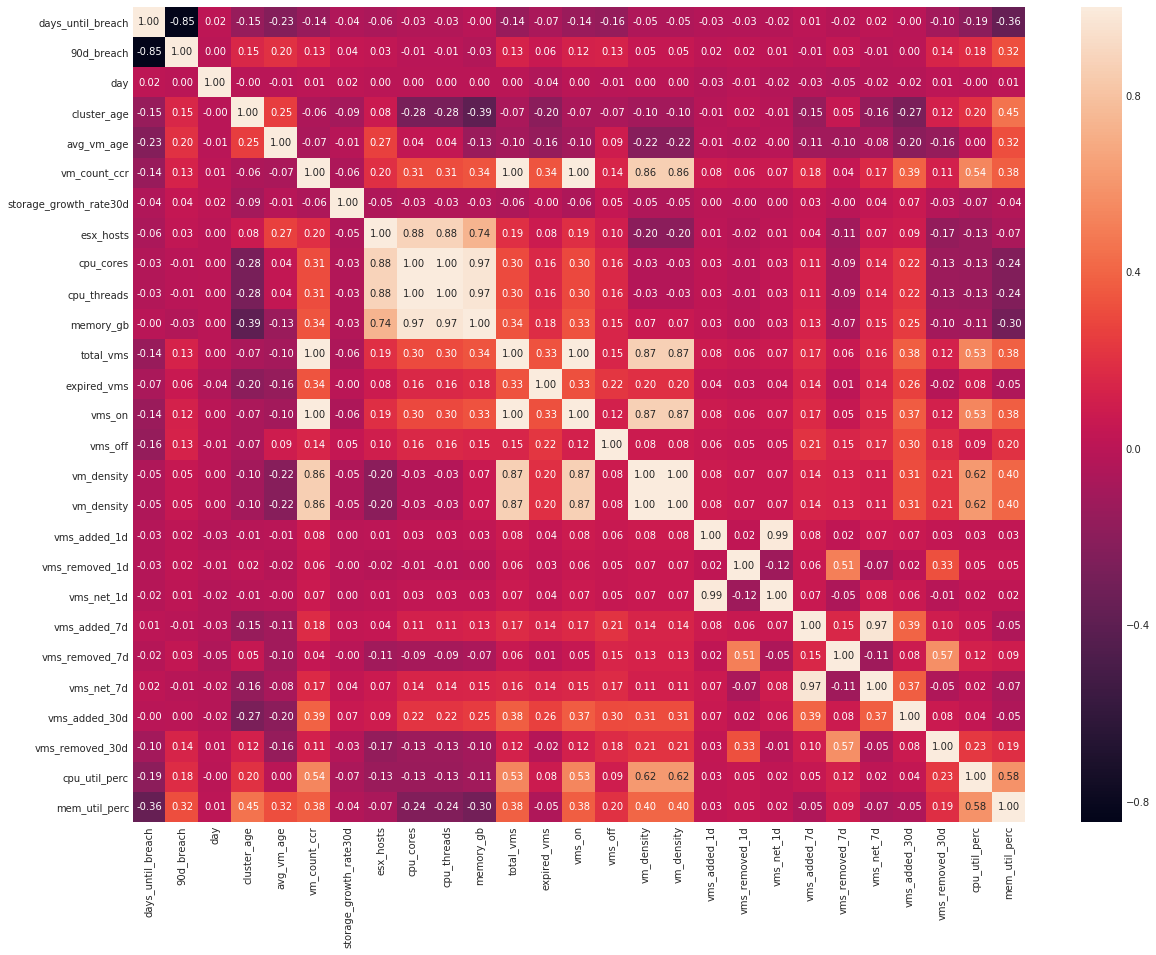

In [35]:
# correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(df_subset.corr(), annot=True, fmt=".2f")

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 53 columns):
date                        4978 non-null object
month                       4978 non-null int64
day                         4978 non-null int64
region                      4978 non-null int64
datacenter                  4978 non-null int64
service                     4978 non-null int64
pipeline_code               4978 non-null int64
pod                         4978 non-null int64
pod_vers                    4978 non-null int64
cluster                     4978 non-null int64
cluster_age                 4978 non-null int64
avg_vm_age                  4978 non-null int64
vm_count_ccr                4978 non-null int64
vc_vm_count                 4978 non-null int64
opthresh                    4978 non-null float64
otis_opstat                 4341 non-null float64
vra_opstat                  0 non-null float64
ccr_opstat                  2245 non-null float64
storage_growth_rate30d 

In [37]:
df_subset.isnull().sum()

days_until_breach           0
90d_breach                  0
month_2                     0
day                         0
region_2                    0
datacenter_2                0
service_2                   0
pod_2                       0
pod_vers_2                  0
cluster_age                 0
avg_vm_age                  0
vm_count_ccr                0
storage_growth_rate30d    635
esx_hosts                 635
cpu_cores                 635
cpu_threads               635
memory_gb                 635
total_vms                 635
expired_vms               635
vms_on                    635
vms_off                   635
vm_density                635
vm_density                635
vms_added_1d              635
vms_removed_1d            635
vms_net_1d                635
vms_added_7d              635
vms_removed_7d            635
vms_net_7d                635
vms_added_30d             635
vms_removed_30d           635
cpu_util_perc               0
mem_util_perc               0
dtype: int

In [38]:
# removing observations with missing values
df_subset = df_subset.dropna()

In [39]:
df_subset.isnull().sum()

days_until_breach         0
90d_breach                0
month_2                   0
day                       0
region_2                  0
datacenter_2              0
service_2                 0
pod_2                     0
pod_vers_2                0
cluster_age               0
avg_vm_age                0
vm_count_ccr              0
storage_growth_rate30d    0
esx_hosts                 0
cpu_cores                 0
cpu_threads               0
memory_gb                 0
total_vms                 0
expired_vms               0
vms_on                    0
vms_off                   0
vm_density                0
vm_density                0
vms_added_1d              0
vms_removed_1d            0
vms_net_1d                0
vms_added_7d              0
vms_removed_7d            0
vms_net_7d                0
vms_added_30d             0
vms_removed_30d           0
cpu_util_perc             0
mem_util_perc             0
dtype: int64

In [40]:
# create X (features) and y (response)
feature_cols = ['cluster_age','avg_vm_age','vm_count_ccr','storage_growth_rate30d','esx_hosts','cpu_cores','cpu_threads','memory_gb', 'total_vms','expired_vms','vms_on','vms_off','vm_density','cpu_util_perc','mem_util_perc']
X = df_subset[feature_cols]
y =  df_subset['days_until_breach']

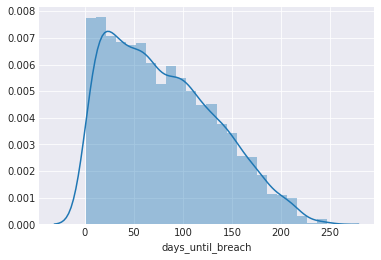

In [41]:
# pdf
sns.distplot(y)

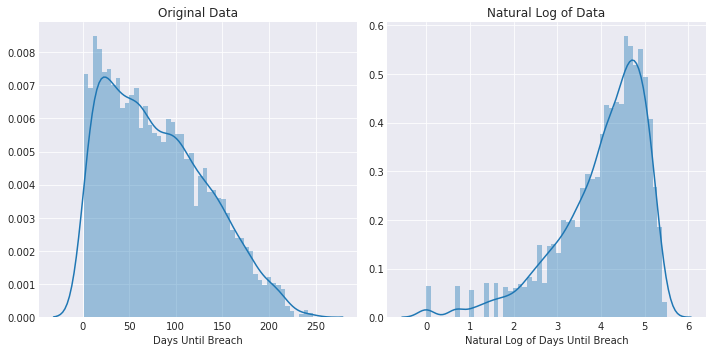

In [43]:
# pdf plot - Naturla Log of y (days until breach)
target = df_subset['days_until_breach']
target_log = np.log(target)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('Days Until Breach')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Days Until Breach')
plt.tight_layout()

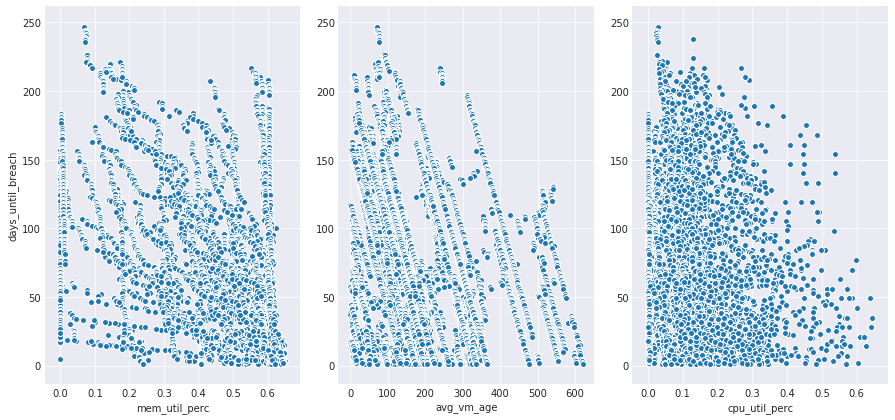

In [44]:
# scatter plot in Seaborn
sns.pairplot(df_subset, x_vars=['mem_util_perc','avg_vm_age','cpu_util_perc'], y_vars='days_until_breach', size=6, aspect=0.7)

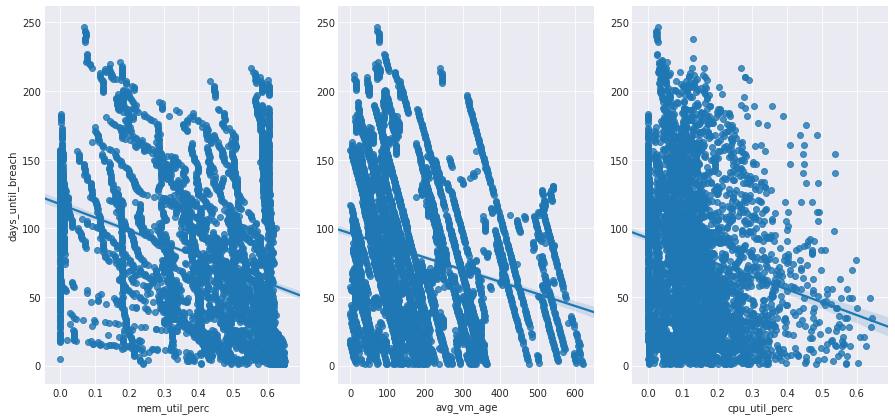

In [45]:
# include a regression line
sns.pairplot(df_subset, x_vars=['mem_util_perc','avg_vm_age','cpu_util_perc'], y_vars='days_until_breach', size=6, aspect=0.7, kind='reg')

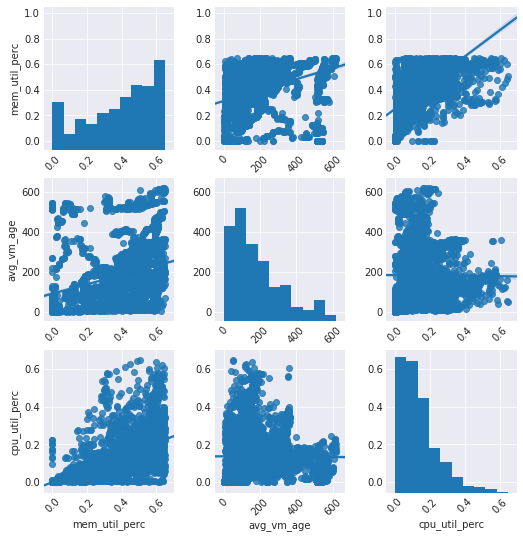

In [46]:
# scatter matrix in seaborn
g = sns.pairplot(df_subset[['mem_util_perc','avg_vm_age','cpu_util_perc']], diag_kind="hist", kind="reg")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

In [51]:
## creating train and test set
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=78978)

In [52]:
print (df_subset.shape)
print (X_train.shape)
print (X_test.shape)

(4343, 33)
(2605, 16)
(1738, 16)


In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4343 entries, 0 to 4977
Data columns (total 16 columns):
cluster_age               4343 non-null int64
avg_vm_age                4343 non-null int64
vm_count_ccr              4343 non-null int64
storage_growth_rate30d    4343 non-null float64
esx_hosts                 4343 non-null float64
cpu_cores                 4343 non-null float64
cpu_threads               4343 non-null float64
memory_gb                 4343 non-null float64
total_vms                 4343 non-null float64
expired_vms               4343 non-null float64
vms_on                    4343 non-null float64
vms_off                   4343 non-null float64
vm_density                4343 non-null float64
vm_density                4343 non-null float64
cpu_util_perc             4343 non-null float64
mem_util_perc             4343 non-null float64
dtypes: float64(13), int64(3)
memory usage: 736.8 KB


In [54]:
df_subset.isnull().sum()

days_until_breach         0
90d_breach                0
month_2                   0
day                       0
region_2                  0
datacenter_2              0
service_2                 0
pod_2                     0
pod_vers_2                0
cluster_age               0
avg_vm_age                0
vm_count_ccr              0
storage_growth_rate30d    0
esx_hosts                 0
cpu_cores                 0
cpu_threads               0
memory_gb                 0
total_vms                 0
expired_vms               0
vms_on                    0
vms_off                   0
vm_density                0
vm_density                0
vms_added_1d              0
vms_removed_1d            0
vms_net_1d                0
vms_added_7d              0
vms_removed_7d            0
vms_net_7d                0
vms_added_30d             0
vms_removed_30d           0
cpu_util_perc             0
mem_util_perc             0
dtype: int64

In [55]:
# create X (features) and y (response)
feature_cols = ['cluster_age','avg_vm_age','vm_count_ccr','storage_growth_rate30d','esx_hosts','cpu_cores','cpu_threads','memory_gb', 'total_vms','expired_vms','vms_on','vms_off','vm_density','cpu_util_perc','mem_util_perc']
X = df_subset[feature_cols]
y =  df_subset['90d_breach']

In [56]:
features = df_subset [['90d_breach','cluster_age','avg_vm_age','vm_count_ccr','storage_growth_rate30d','esx_hosts','cpu_cores','cpu_threads','memory_gb', 'total_vms','expired_vms','vms_on','vms_off','vm_density','cpu_util_perc','mem_util_perc']]

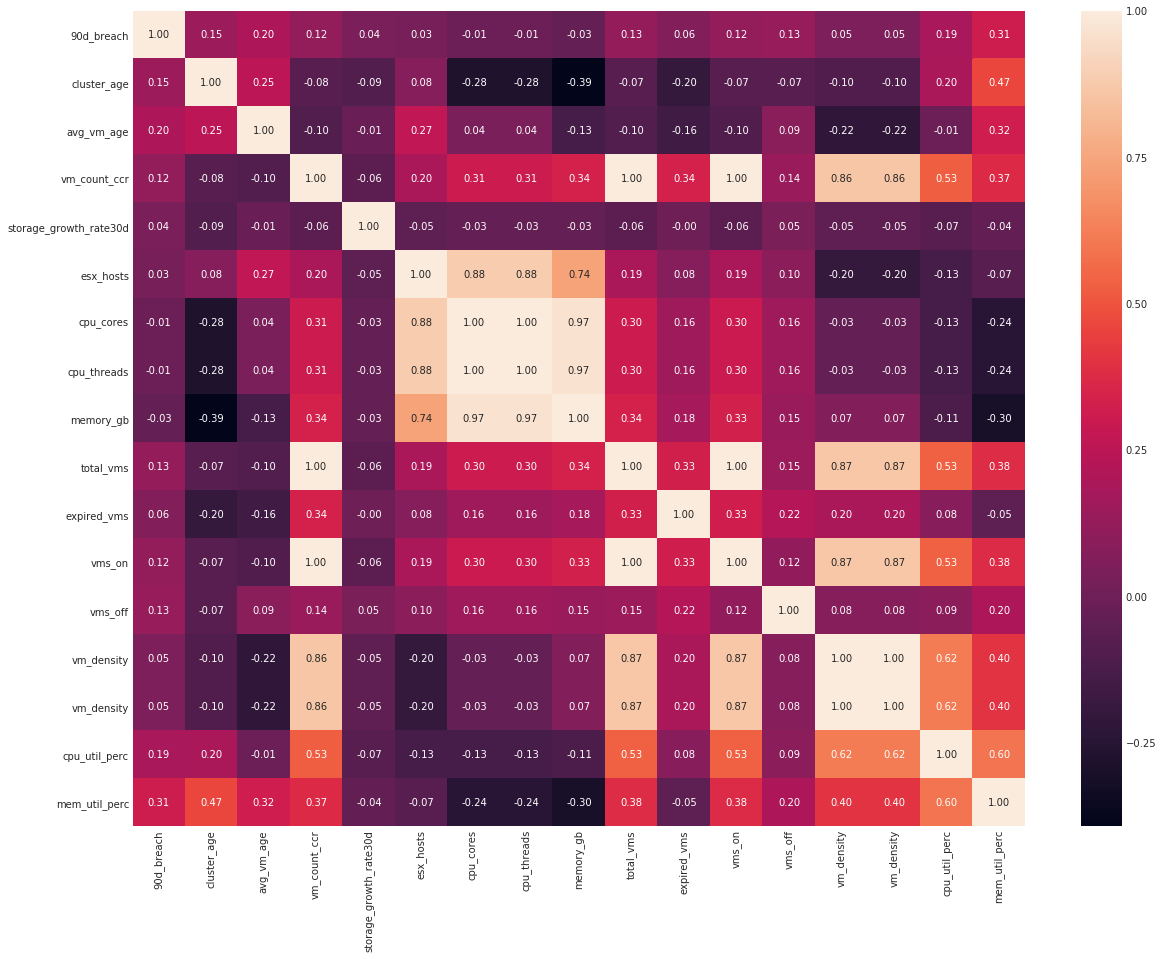

In [57]:
# correlation matrix for subset of the data (only chosen features)
plt.figure(figsize=(20, 15))
sns.heatmap(features.corr(), annot=True, fmt=".2f")

In [58]:
# g = sns.FacetGrid(features, row='90d_breach', col='mem_util_perc')
# g.map(sns.distplot, "avg_vm_age")
# sns.plt.show()

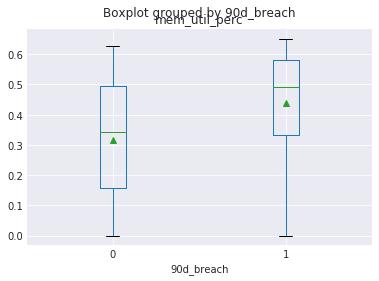

In [59]:
# box plot for 'suspicous' feature
# trying to find features that divide our dataset into two categories
# - will breach within 90 days (90d_breach == 1) 
# - won't breach within 90 days (90d_breach == 0)
features.boxplot(column='mem_util_perc', by='90d_breach', showmeans=True)

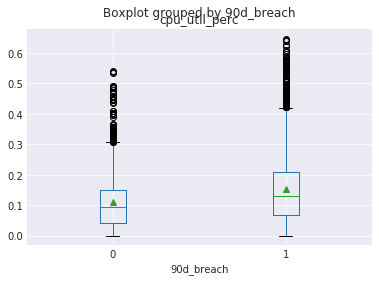

In [60]:
features.boxplot(column='cpu_util_perc', by='90d_breach', showmeans=True)

In [61]:
# df_subset.boxplot(column='mem_util_perc', by='days_until_breach', showmeans=True)

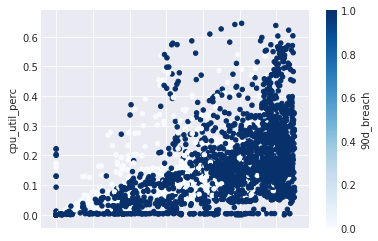

In [62]:
# vary point color by mem and cpu utilization
features.plot(kind='scatter', x='mem_util_perc', y='cpu_util_perc', c='90d_breach', colormap='Blues')

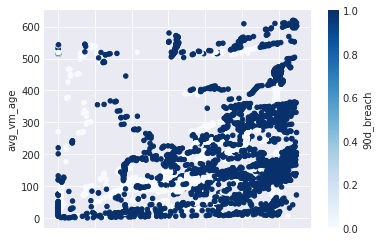

In [63]:
# vary point color by mem and cpu utilization
features.plot(kind='scatter', x='mem_util_perc', y='avg_vm_age', c='90d_breach', colormap='Blues')

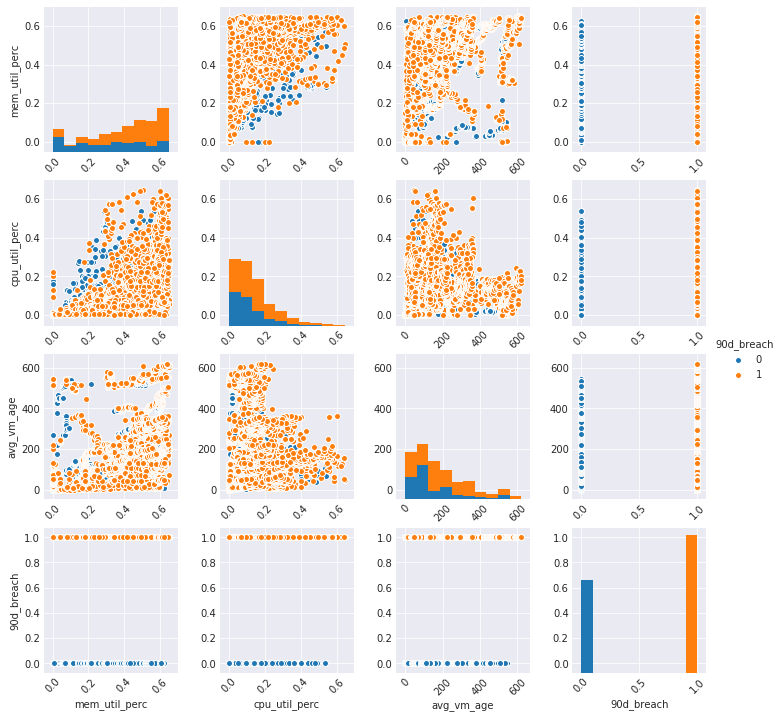

In [64]:
g = sns.pairplot(features[["mem_util_perc", "cpu_util_perc", "avg_vm_age", "90d_breach"]], hue="90d_breach", diag_kind="hist")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

In [141]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=78978)

In [142]:
# Linear Regression
# instantiate and fit
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [143]:
# print the coefficients
print (linreg.intercept_)
print (linreg.coef_)

0.4450747001305666
[ 5.92e-04  4.44e-04 -1.71e-03  1.38e-06 -1.34e-01  1.06e-03  2.11e-03
 -7.21e-05  1.74e-03  2.25e-02  1.72e-03  2.19e-05 -1.15e-02 -1.15e-02
  5.02e-01  6.98e-01]


In [144]:
# calculate the R-squared value for the model
y_pred = linreg.predict(X_train)
metrics.r2_score(y_train, y_pred)

0.1831650938945637

In [145]:
# logisitc regression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [146]:
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.7289988492520139


In [147]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.6047180667433832
0.39528193325661676


In [148]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[395, 292],
       [179, 872]])

In [149]:
pd.crosstab(y_test, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,395,292,687
1,179,872,1051
All,574,1164,1738


In [150]:
# calculate the accuracy
float(395 + 872) / float(395 + 872 +292 + 179)

0.7289988492520139

In [151]:
# calculate the sensitivity
872 / float(872 + 179)

0.829686013320647

In [152]:
# calculate the specificity
395 / float(395 + 292)

0.5749636098981077

In [153]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Text(0,0.5,u'Frequency')

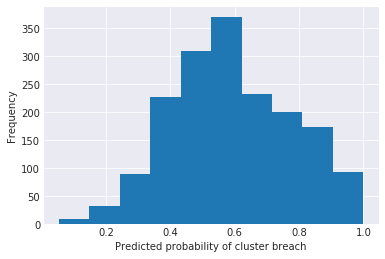

In [154]:
# plot the predicted probabilities
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of cluster breach')
plt.ylabel('Frequency')

In [155]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
#y_pred_class = binarize(y_pred_prob, 0.25)
y_pred_class = binarize(y_pred_prob.reshape(1, -1), 0.25)

In [156]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test[0:], y_pred_class[0]).ravel()

In [157]:
# Accuracy = (TP + TN)/ (TP +TN+ FP+FN)
float(tp + tn) / float(tp + tn + fp + fn)

0.6311852704257768

In [158]:
# Precision = Positive Predictive Value = TP / (TP + FP)
float(tp) / float(tp + fp)

0.621301775147929

In [159]:
# Recall = TP / P = TP / (TP + FN)
float(tp) / float(tp + fn)

0.9990485252140818

In [160]:
# BUILT OFF OF - https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

('Recall metric in the testing dataset: ', 1.0)
('Recall metric in the testing dataset: ', 1.0)
('Recall metric in the testing dataset: ', 0.9971455756422455)
('Recall metric in the testing dataset: ', 0.9295908658420552)
('Recall metric in the testing dataset: ', 0.8287345385347288)
('Recall metric in the testing dataset: ', 0.5699333967649858)
('Recall metric in the testing dataset: ', 0.3396764985727878)
('Recall metric in the testing dataset: ', 0.1636536631779258)
('Recall metric in the testing dataset: ', 0.05137963843958135)


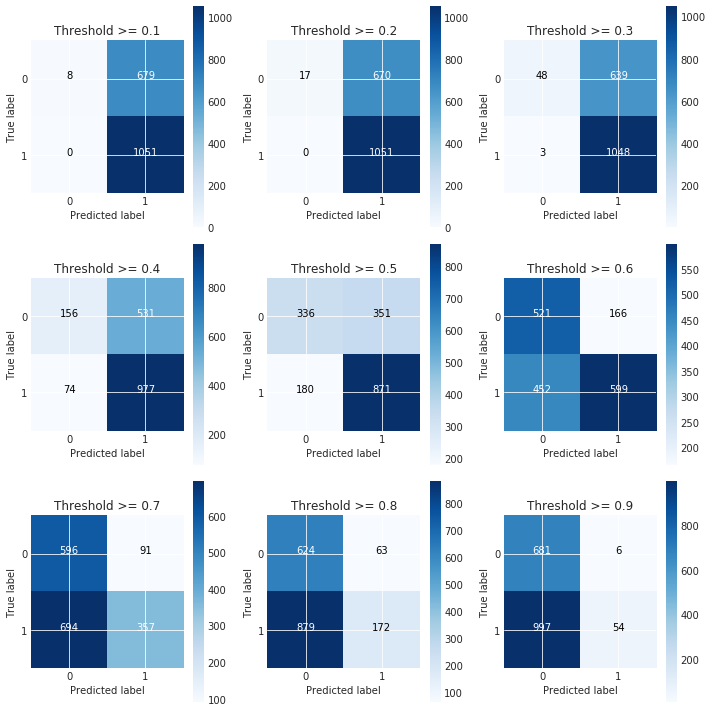

In [93]:
logreg2 = LogisticRegression(C= 0.01, penalty='l1')
logreg2.fit(X_train, y_train)
y_pred_proba2 = logreg2.predict_proba(X_test)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(10,10))

j = 1

for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba2[:, 1] > i
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1]) / float((cnf_matrix[1,0] + cnf_matrix[1,1])))

    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s'%i) 

In [94]:
###############################################################
##################   same thing but with less features

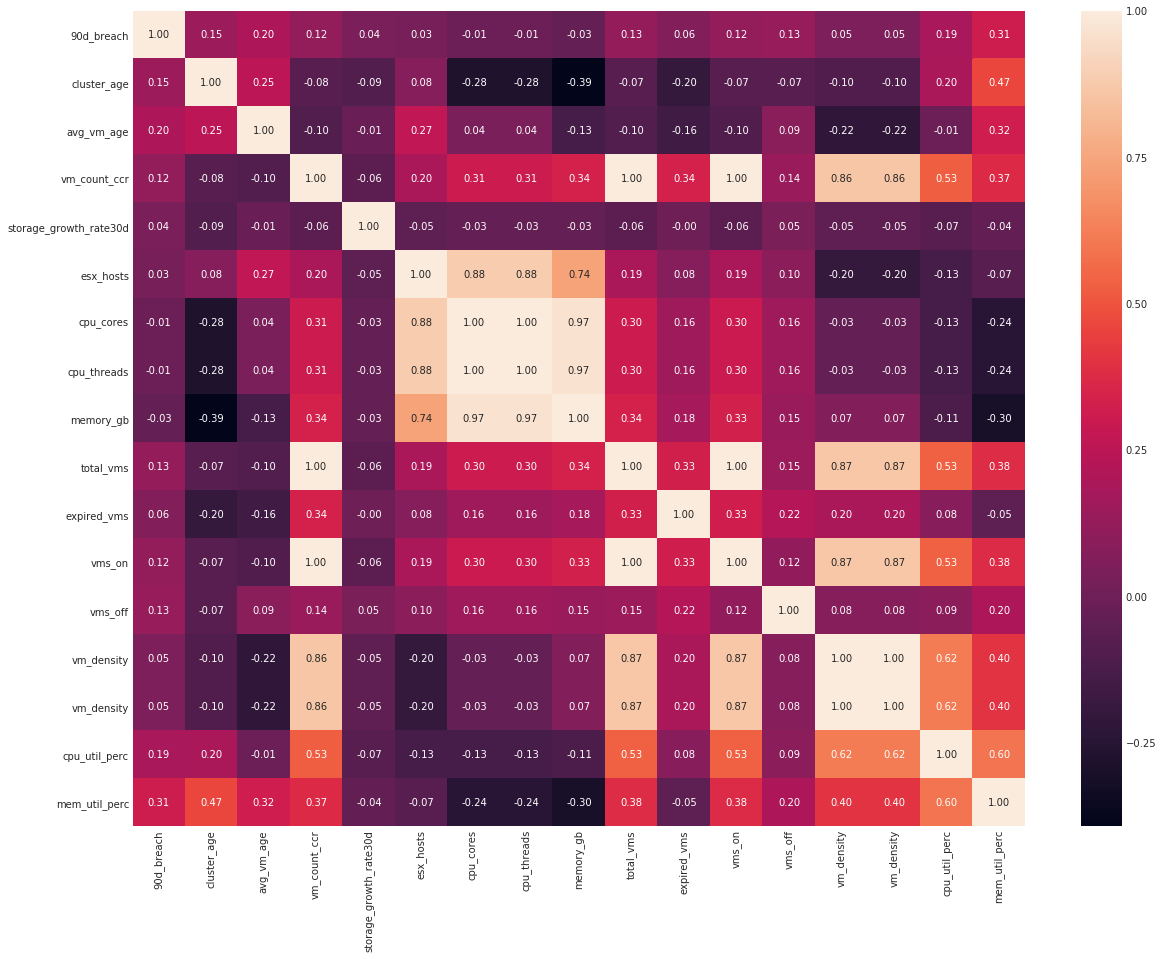

In [161]:
plt.figure(figsize=(20, 15))
sns.heatmap(features.corr(), annot=True, fmt=".2f")

In [162]:
# create X (features) and y (response)
feature_cols8 = ['cluster_age','avg_vm_age','vm_count_ccr', 'total_vms','vms_on','vms_off','cpu_util_perc','mem_util_perc']
X8 = df_subset[feature_cols8]
y8 =  df_subset['90d_breach']

In [163]:
# Split fo rtrain and test set

X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, y8, test_size=0.4, random_state=78978)

In [168]:
print (X8.shape)
print (X_train8.shape)
print (X_test8.shape)

(4343, 8)
(2605, 8)
(1738, 8)


In [169]:
## logistic regression
logreg8 = LogisticRegression(C=1e9)
logreg8.fit(X_train8, y_train8)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [170]:
y_pred_class8 = logreg8.predict(X_test8)

print (metrics.accuracy_score(y_test8, y_pred_class8))

0.6829689298043728


In [171]:
# compute null accuracy manually
print (y_test8.mean())
print (1 - y_test8.mean())

0.6047180667433832
0.39528193325661676


In [172]:
metrics.confusion_matrix(y_test8, y_pred_class8)

array([[313, 374],
       [177, 874]])

In [173]:
# confusion matrix
confmatrix = metrics.confusion_matrix(y_test8, y_pred_class8)

In [174]:
# calculate the accuracy
print(float(313 + 874) / float(313 + 874 + 177 + 374))

# calculate the sensitivity
print(874 / float(874 + 177))

# calculate the specificity
print(313 / float(313 + 374))

0.682968929804
0.831588962892
0.455604075691


In [175]:
confmatrix[0,0]

313

In [176]:
confmatrix[0,1]

374

In [177]:
confmatrix[1,0]

177

In [178]:
# calculate the accuracy
print(float(confmatrix[0,0] + confmatrix[1,1]) / float(confmatrix[0,0] + confmatrix[1,1] + confmatrix[1,0] + confmatrix[0,1]))

# calculate the sensitivity
print(confmatrix[1,1] / float(confmatrix[1,1] + confmatrix[1,0]))

# calculate the specificity
print(confmatrix[0,0] / float(confmatrix[0,0] + confmatrix[0,1]))

0.682968929804
0.8315889628924833
0.4556040756914119


In [179]:
#############################################
######################   only 4 variables ######################

In [180]:
feature_cols4 = ['cluster_age','avg_vm_age','cpu_util_perc','mem_util_perc']
X4 = df_subset[feature_cols4]
y4 =  df_subset['90d_breach']

# Split fo rtrain and test set
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.4, random_state=78978)

print (X4.shape)
print (X_train4.shape)
print (X_test4.shape)

## logistic regression
logreg4 = LogisticRegression(C=1e9)
logreg4.fit(X_train4, y_train4)

y_pred_class4 = logreg4.predict(X_test4)

print (metrics.accuracy_score(y_test4, y_pred_class4))

# compute null accuracy manually
print (y_test4.mean())
print (1 - y_test4.mean())

confmatrix4 = metrics.confusion_matrix(y_test4, y_pred_class4)

# confusion matrix
metrics.confusion_matrix(y_test4, y_pred_class4)


# calculate the accuracy
print(float(confmatrix4[0,0] + confmatrix4[1,1]) / float(confmatrix4[0,0] + confmatrix4[1,1] + confmatrix4[1,0] + confmatrix4[0,1]))
# calculate the sensitivity
print(confmatrix4[1,1] / float(confmatrix4[1,1] + confmatrix4[1,0]))
# calculate the specificity
print(confmatrix4[0,0] / float(confmatrix4[0,0] + confmatrix4[0,1]))

(4343, 4)
(2605, 4)
(1738, 4)
0.6800920598388953
0.6047180667433832
0.39528193325661676
0.680092059839
0.8363463368220743
0.4410480349344978


In [181]:

# confusion matrix
metrics.confusion_matrix(y_test4, y_pred_class4)

array([[303, 384],
       [172, 879]])

In [182]:

# calculate the accuracy
print(float(confmatrix4[0,0] + confmatrix4[1,1]) / float(confmatrix4[0,0] + confmatrix4[1,1] + confmatrix4[1,0] + confmatrix4[0,1]))

# calculate the sensitivity
print(confmatrix4[1,1] / float(confmatrix4[1,1] + confmatrix4[1,0]))

# calculate the specificity
print(confmatrix4[0,0] / float(confmatrix4[0,0] + confmatrix4[0,1]))

0.680092059839
0.8363463368220743
0.4410480349344978


In [183]:
# create a DataFrame with the two dummy variable columns
region_2_dummies = pd.get_dummies(df.region_2, prefix='region_2').iloc[:, 1:]
# region_2_dummies = pd.get_dummies(df.region_2, prefix='reion_2').iloc[0,1,2,3]

In [184]:
datacenter_2_dummies = pd.get_dummies(df.datacenter_2, prefix='datacenter_2').iloc[:, 1:]

In [185]:
service_2_dummies = pd.get_dummies(df.service_2, prefix='service_2').iloc[:, 1:]

In [186]:
pipeline_code_2_dummies = pd.get_dummies(df.pipeline_code_2, prefix='pipeline_code_2').iloc[:, 1:]

In [187]:
pod_2_dummies = pd.get_dummies(df.pod_2, prefix='pod_2').iloc[:, 1:]

In [188]:
pod_vers_2_dummies = pd.get_dummies(df.pod_vers_2, prefix='pod_vers_2').iloc[:, 1:]

In [189]:
region_2_dummies.head(5)

,region_2_B,region_2_C,region_2_D
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0


In [190]:
datacenter_2_dummies.head(5)

,datacenter_2_B,datacenter_2_C,datacenter_2_D,datacenter_2_E,datacenter_2_F,datacenter_2_G,datacenter_2_H,datacenter_2_I,datacenter_2_J,datacenter_2_K
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [191]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
df = pd.concat([df, region_2_dummies], axis=1)
df.head()

,date,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,...,pod_2_U,pod_2_V,pod_2_W,pod_2_X,pod_2_Z,pod_vers_2_B,pod_vers_2_C,region_2_B,region_2_C,region_2_D
0,10/13/2017,10,13,1,10,4,2,3,2,13,...,0,0,0,0,0,1,0,0,0,0
1,10/13/2017,10,13,1,10,11,6,3,2,16,...,0,0,0,0,0,1,0,0,0,0
2,10/13/2017,10,13,1,10,11,6,3,2,14,...,0,0,0,0,0,1,0,0,0,0
3,10/13/2017,10,13,2,2,4,2,5,2,21,...,0,0,0,0,0,1,0,1,0,0
4,10/13/2017,10,13,2,2,11,6,5,2,23,...,0,0,0,0,0,1,0,1,0,0


In [192]:
df = pd.concat([df, datacenter_2_dummies], axis=1)

In [193]:
df = pd.concat([df, service_2_dummies], axis=1)

In [194]:
df = pd.concat([df, pipeline_code_2_dummies], axis=1)

In [195]:
df = pd.concat([df, pod_2_dummies], axis=1)

In [196]:
df = pd.concat([df, pod_vers_2_dummies], axis=1)

In [197]:
df.head()

,date,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,...,pod_2_Q,pod_2_R,pod_2_T,pod_2_U,pod_2_V,pod_2_W,pod_2_X,pod_2_Z,pod_vers_2_B,pod_vers_2_C
0,10/13/2017,10,13,1,10,4,2,3,2,13,...,0,0,0,0,0,0,0,0,1,0
1,10/13/2017,10,13,1,10,11,6,3,2,16,...,0,0,0,0,0,0,0,0,1,0
2,10/13/2017,10,13,1,10,11,6,3,2,14,...,0,0,0,0,0,0,0,0,1,0
3,10/13/2017,10,13,2,2,4,2,5,2,21,...,0,0,0,0,0,0,0,0,1,0
4,10/13/2017,10,13,2,2,11,6,5,2,23,...,0,0,0,0,0,0,0,0,1,0


In [198]:
df.shape

(4978, 153)

In [199]:
df.columns

Index([u'date', u'month', u'day', u'region', u'datacenter', u'service',
       u'pipeline_code', u'pod', u'pod_vers', u'cluster',
       ...
       u'pod_2_Q', u'pod_2_R', u'pod_2_T', u'pod_2_U', u'pod_2_V', u'pod_2_W',
       u'pod_2_X', u'pod_2_Z', u'pod_vers_2_B', u'pod_vers_2_C'],
      dtype='object', length=153)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Columns: 153 entries, date to pod_vers_2_C
dtypes: float64(27), int64(18), object(8), uint8(100)
memory usage: 2.5+ MB


In [201]:
dforg.head()

,date,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,...,vms_net_30d,cpu_util_perc,mem_util_perc,breach,breach_reason,breach_date,total_days_before_breach,days_until_breach,90d_breach,days_since_breach
0,10/13/2017,10,13,1,10,4,2,3,2,13,...,-21.0,0.3570,0.5736,0,NaN,1511222400,498,39,1,NaN
1,10/13/2017,10,13,1,10,11,6,3,2,16,...,23.0,0.0691,0.5143,0,NaN,1509753600,173,22,1,NaN
2,10/13/2017,10,13,1,10,11,6,3,2,14,...,4.0,0.1695,0.5159,0,NaN,1513987200,530,71,1,NaN
3,10/13/2017,10,13,2,2,4,2,5,2,21,...,14.0,0.0376,0.1436,0,NaN,1526860800,641,220,0,NaN
4,10/13/2017,10,13,2,2,11,6,5,2,23,...,7.0,0.0284,0.2973,0,NaN,1520985600,572,152,0,NaN


In [202]:
#############################################################################################################

In [203]:
df.head()

,date,month,day,region,datacenter,service,pipeline_code,pod,pod_vers,cluster,...,pod_2_Q,pod_2_R,pod_2_T,pod_2_U,pod_2_V,pod_2_W,pod_2_X,pod_2_Z,pod_vers_2_B,pod_vers_2_C
0,10/13/2017,10,13,1,10,4,2,3,2,13,...,0,0,0,0,0,0,0,0,1,0
1,10/13/2017,10,13,1,10,11,6,3,2,16,...,0,0,0,0,0,0,0,0,1,0
2,10/13/2017,10,13,1,10,11,6,3,2,14,...,0,0,0,0,0,0,0,0,1,0
3,10/13/2017,10,13,2,2,4,2,5,2,21,...,0,0,0,0,0,0,0,0,1,0
4,10/13/2017,10,13,2,2,11,6,5,2,23,...,0,0,0,0,0,0,0,0,1,0


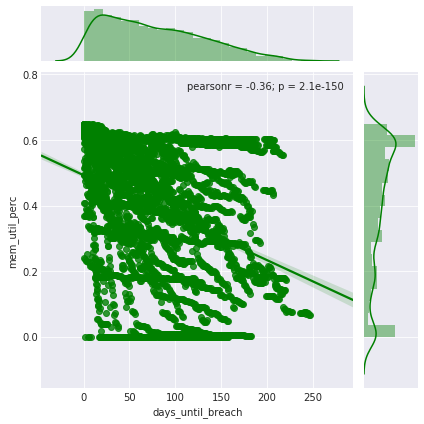

In [204]:
sns.jointplot(data=df, x='days_until_breach', y='mem_util_perc', kind='reg', color='g')
#sns.plt.show()

ValueError: max must be larger than min in range parameter.

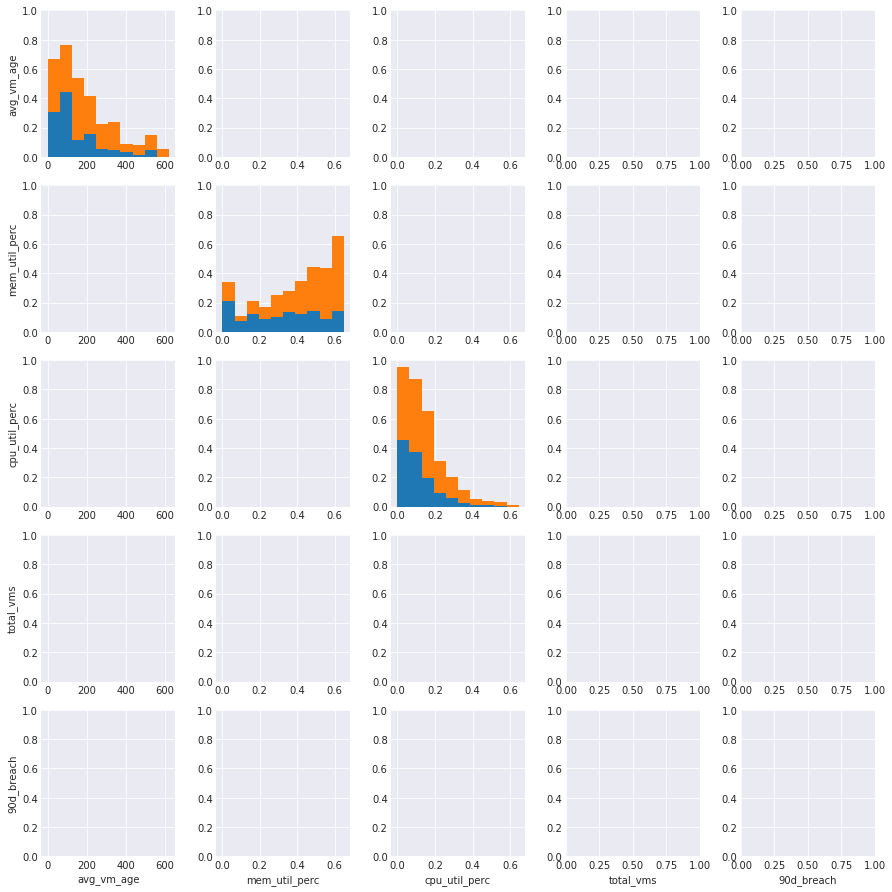

In [205]:
g = sns.pairplot(df[["avg_vm_age", "mem_util_perc", "cpu_util_perc", "total_vms", "90d_breach"]], hue="90d_breach", diag_kind="hist")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

In [206]:
sns.pairplot(readm[["avg_vm_age", "mem_util_perc", "cpu_util_perc", "total_vms", "90d_breach"]], hue="90d_breach", diag_kind="hist")

NameError: name 'readm' is not defined

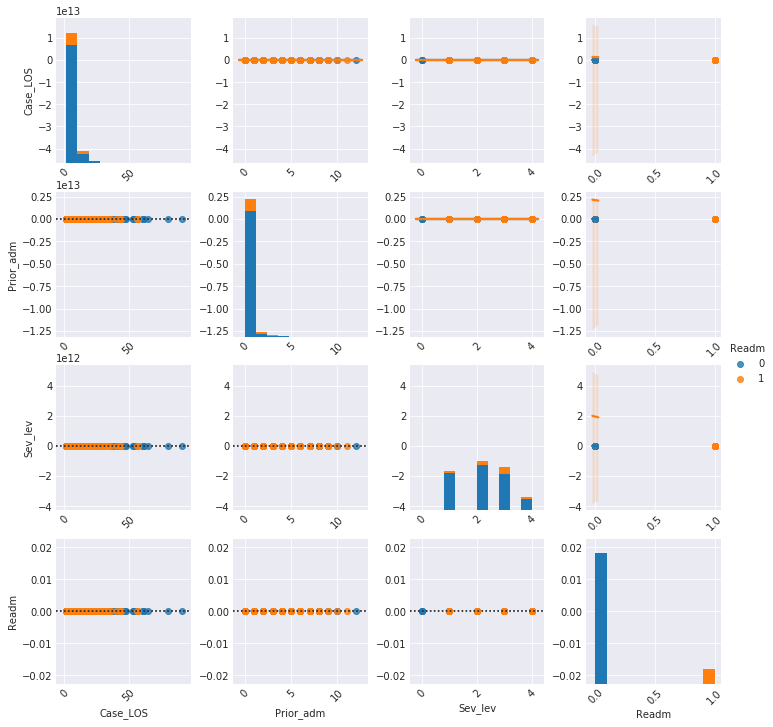

In [0]:
g = sns.PairGrid(readm[["Case_LOS", "Prior_adm", "Sev_lev","Readm"]], hue="Readm")
g.map_upper(sns.regplot)
g.map_lower(sns.residplot)
g.map_diag(plt.hist)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)
g.add_legend()
g.set(alpha=0.5)

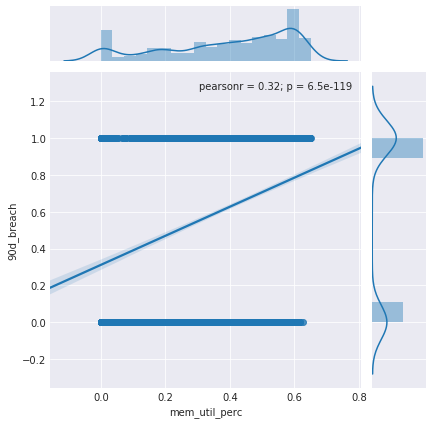

In [208]:
sns.jointplot("mem_util_perc", "90d_breach", data=df, kind="reg")

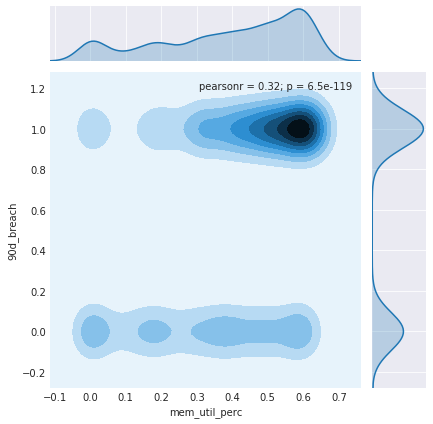

In [209]:
sns.jointplot("mem_util_perc", "90d_breach", data=df, kind='kde')

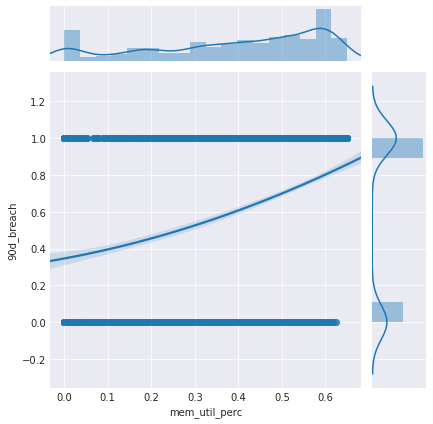

In [210]:
g = sns.JointGrid(x="mem_util_perc", y="90d_breach", data=df)
g.plot_joint(sns.regplot, order=2)
g.plot_marginals(sns.distplot)

In [ ]:
################################### knn method for clasisfication problem #########################

In [211]:
## #knn
# import the class
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [212]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [213]:
# store the predicted response values
y_pred = knn.predict(X)

In [214]:
y_pred.shape

(4343,)

In [217]:
df_subset["y_pred"]=y_pred

In [218]:
df_subset.head()

,days_until_breach,90d_breach,month_2,day,region_2,datacenter_2,service_2,pod_2,pod_vers_2,cluster_age,...,vms_removed_1d,vms_net_1d,vms_added_7d,vms_removed_7d,vms_net_7d,vms_added_30d,vms_removed_30d,cpu_util_perc,mem_util_perc,y_pred
0,39,1,Oct,13,A,J,J,C,B,459,...,0.0,0.0,0.0,3.0,-3.0,0.0,21.0,0.3570,0.5736,1
1,22,1,Oct,13,A,J,J,C,B,151,...,0.0,0.0,5.0,0.0,5.0,23.0,0.0,0.0691,0.5143,1
2,71,1,Oct,13,A,J,J,C,B,459,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.1695,0.5159,1
3,220,0,Oct,13,B,B,B,E,B,421,...,0.0,0.0,6.0,0.0,6.0,14.0,0.0,0.0376,0.1436,0
4,152,0,Oct,13,B,B,B,E,B,420,...,0.0,0.0,5.0,1.0,4.0,7.0,0.0,0.0284,0.2973,0


In [219]:
df_subset.to_csv('new_df_all_data.csv', sep=',')

In [220]:
# compute classification accuracy
from sklearn import metrics
print (metrics.accuracy_score(y, y_pred))

0.9919410545705734


In [221]:
metrics.confusion_matrix(y, y_pred)

array([[1743,    2],
       [  33, 2565]])

In [222]:
# calculate the sensitivity
206 / float(1406 + 206)

0.12779156327543426

In [223]:
# calculate the specificity
14304 / float(14304 + 56)

0.996100278551532

In [224]:
pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1743,2,1745
1,33,2565,2598
All,1776,2567,4343


In [225]:
#############################################################################################

In [226]:
#### do the same for train and test sets

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=78978)


In [236]:
print(X_train.head())
print(y_train.head())

      cluster_age  avg_vm_age  vm_count_ccr  storage_growth_rate30d  \
654           450         208           122              172.051447   
1632           88          26             2                0.066124   
2047          586         373           277                1.070652   
2664          306         287           272                9.286380   
2728          134          72             2              -21.405253   

      esx_hosts  cpu_cores  cpu_threads    memory_gb  total_vms  expired_vms  \
654        16.0      384.0        768.0  8188.000000      122.0          0.0   
1632        8.0      288.0        576.0  8190.240234        2.0          0.0   
2047       12.0      288.0        576.0  6141.000000      279.0          0.0   
2664       14.0      336.0        672.0  7164.739990      272.0          0.0   
2728        8.0      288.0        576.0  8190.240234        3.0          2.0   

      vms_on  vms_off  vm_density  vm_density  cpu_util_perc  mem_util_perc  
654    121.0  

In [229]:
print (df_subset.shape)
print (X_train.shape)
print (X_test.shape)

(4343, 34)
(2605, 16)
(1738, 16)


In [230]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
print (metrics.accuracy_score(y_test, y_test_pred))

0.9631760644418872


In [231]:
# calculate TRAINING ERROR and TESTING ERROR for K=1 through 50
k_range = range(1, 51)
training_error = []
testing_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # training error
    knn.fit(X, y)
    y_pred = knn.predict(X)
    training_error.append(1 - metrics.accuracy_score(y, y_pred))
    # testing error
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    testing_error.append(1 - metrics.accuracy_score(y_test, y_pred))

In [232]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Text(0,0.5,u'Testing Error')

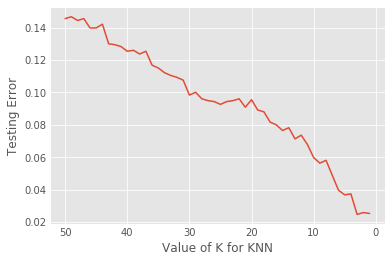

In [233]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
plt.plot(k_range, testing_error)
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Error')

In [234]:
# create a DataFrame of K, training error, and testing error
df = pd.DataFrame({'K': k_range, 'train':training_error, 'test':testing_error}).set_index('K').sort_index(ascending=False)
df

,test,train
K,,
50,0.145570,0.084964
49,0.146720,0.084043
48,0.144419,0.085425
47,0.145570,0.084964
46,0.139816,0.084964
45,0.139816,0.083813
44,0.142117,0.084504
43,0.130035,0.083583
42,0.129459,0.083122


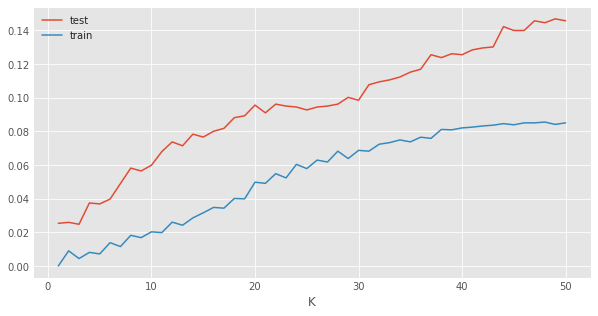

In [235]:
# plot the relationship between K (HIGH TO LOW) and both TRAINING ERROR and TESTING ERROR
df.plot(figsize=(10,5))

In [237]:
knn17 = KNeighborsClassifier(n_neighbors=17)
knn17.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [238]:
# STEP 3: test the model on the testing set, and check the accuracy
y_test_pred = knn.predict(X_test)
print (metrics.accuracy_score(y_test, y_test_pred))

0.8544303797468354


In [239]:
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,552,135,687
1,118,933,1051
All,670,1068,1738


In [240]:
# calculate the sensitivity
25 / float(622 + 25)

0.03863987635239567

In [241]:
# calculate the specificity
5730 / float(5730 + 12)

0.9979101358411703

In [242]:
# X_test['y_pred'] = y_pred

In [0]:
#####    Logistic Regression #################

In [243]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [244]:
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.7289988492520139


In [245]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.6047180667433832
0.39528193325661676


In [246]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[395, 292],
       [179, 872]])

In [247]:
# calculate the sensitivity
15 / float(632 + 15)

0.023183925811437404

In [248]:
# calculate the specificity
5717 / float(5717 + 25)

0.9956461163357715

In [249]:
pd.crosstab(y_test, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,395,292,687
1,179,872,1051
All,574,1164,1738


In [250]:
logreg.predict_proba(X_test)

array([[0.48, 0.52],
       [0.77, 0.23],
       [0.52, 0.48],
       ...,
       [0.6 , 0.4 ],
       [0.3 , 0.7 ],
       [0.49, 0.51]])

In [251]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [252]:
y_pred_prob

array([0.52, 0.23, 0.48, ..., 0.4 , 0.7 , 0.51])

Text(0,0.5,u'Frequency')

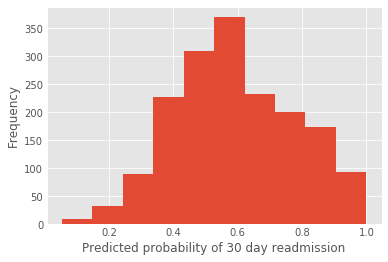

In [253]:
# plot the predicted probabilities
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of 30 day readmission')
plt.ylabel('Frequency')

In [254]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)

In [255]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
#y_pred_class = binarize(y_pred_prob, 0.25)
y_pred_class = binarize(y_pred_prob.reshape(1, -1), 0.25)

In [256]:
# new confusion matrix. Columns=Predicted NO, YES; Row=Actual NO, YES. 
# sensitivity = True Positive / Actual YES
# specificity = True Negative / Actual NO
print (metrics.confusion_matrix(y_test[0:], y_pred_class[0]))

[[  47  640]
 [   1 1050]]


In [257]:
# new sensitivity
print (81 / float(566 + 81))

0.125193199382


In [258]:
# new specificity
print (5546 / float(5546 + 196))

0.965865552072


In [259]:
pd.crosstab(y_test[0:], y_pred_class[0], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,47,640,687
1,1,1050,1051
All,48,1690,1738


In [261]:
###############   PRECISION RECALL TRADEOFF ###############################################

In [262]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test[0:], y_pred_class[0]).ravel()

In [263]:
# Precision = Positive Predictive Value = TP / (TP + FP)
float(tp) / float(tp + fp)

0.621301775147929

In [264]:
# Recall = TP / P = TP / (TP + FN)
float(tp) / float(tp + fn)

0.9990485252140818

In [265]:
metrics.recall_score(y_test[0:], y_pred_class[0])

0.9990485252140818

In [266]:
# BUILT OFF OF - https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

('Recall metric in the testing dataset: ', 1.0)
('Recall metric in the testing dataset: ', 1.0)
('Recall metric in the testing dataset: ', 0.8287345385347288)
('Recall metric in the testing dataset: ', 0.3396764985727878)
('Recall metric in the testing dataset: ', 1.0)
('Recall metric in the testing dataset: ', 0.9971455756422455)
('Recall metric in the testing dataset: ', 0.8287345385347288)
('Recall metric in the testing dataset: ', 0.3396764985727878)
('Recall metric in the testing dataset: ', 0.05137963843958135)


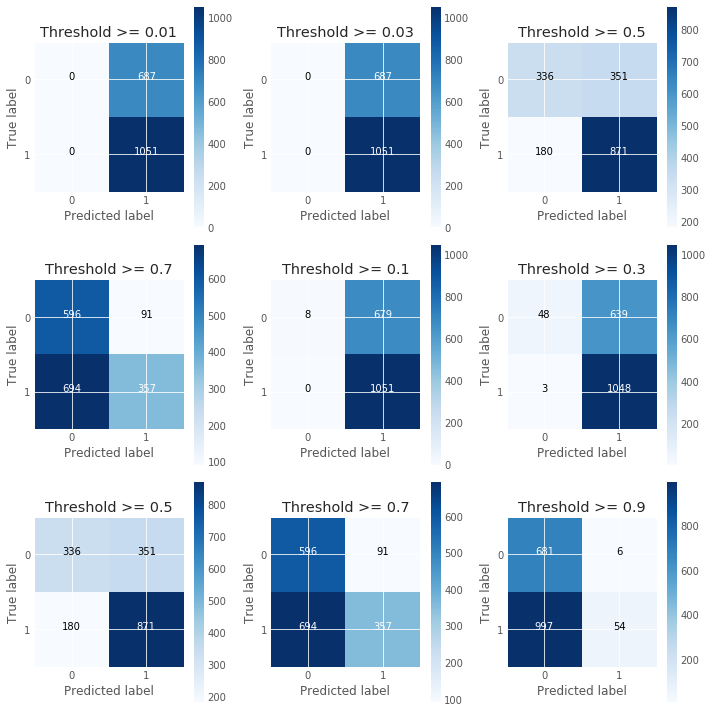

In [267]:
logreg2 = LogisticRegression(C= 0.01, penalty='l1')
logreg2.fit(X_train, y_train)
y_pred_proba2 = logreg2.predict_proba(X_test)

thresholds = [0.01, 0.03, 0.5, 0.7, 0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(10,10))

j = 1

for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba2[:, 1] > i
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1]) / float((cnf_matrix[1,0] + cnf_matrix[1,1])))

    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s'%i) 

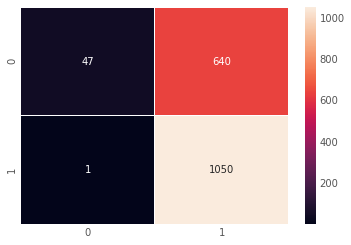

In [268]:
import seaborn as sns
conf = metrics.confusion_matrix(y_test[0:], y_pred_class[0])
sns.heatmap(conf, annot=True, fmt="d", linewidths=.5)

In [269]:
###  ROC CURVES AND AUC

In [270]:
# predict probability of survival
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Text(0,0.5,u'True Positive Rate (Sensitivity)')

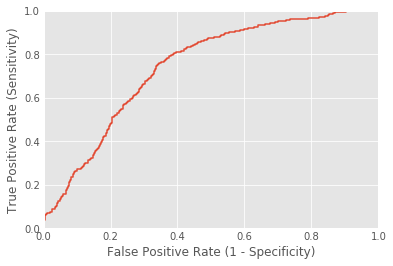

In [271]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [272]:
# calculate AUC
print (metrics.roc_auc_score(y_test, y_pred_prob))

0.7433940365936926


In [273]:
# calculate AUC using y_pred_class (producing incorrect results)
print (metrics.roc_auc_score(y_test[0:], y_pred_class[0]))

0.5337309583857891


In [274]:
y_pred_class.shape

(1, 1738)

In [275]:
y_test.shape

(1738,)

In [276]:
 y_pred_class[0:]

array([[1., 0., 1., ..., 1., 1., 1.]])

In [277]:
y_test[0:]

1903    0
362     0
1024    0
3815    1
2508    0
601     1
1535    1
2166    1
1496    0
706     0
3792    0
1138    1
193     0
3762    1
2458    0
3227    0
998     0
733     1
4903    1
361     1
2786    1
1054    1
3684    1
3394    1
251     0
280     1
2082    0
952     1
3190    0
2401    1
       ..
3948    1
673     0
149     0
1       1
3739    1
1945    0
2933    1
4840    1
1322    1
3632    1
1169    1
1660    0
1880    0
2453    0
4159    1
3109    1
800     1
2034    1
3279    1
4       0
805     0
3851    1
4787    1
3452    1
1353    1
3552    1
4175    1
1661    0
2735    1
2169    0
Name: 90d_breach, Length: 1738, dtype: int64

In [278]:
# new confusion matrix. Columns=Predicted NO, YES; Row=Actual NO, YES. 
# sensitivity = True Positive / Actual YES
# specificity = True Negative / Actual NO
print (metrics.confusion_matrix(y_test[0:], y_pred_class[0]))

[[  47  640]
 [   1 1050]]


In [279]:
X_test.head()

,cluster_age,avg_vm_age,vm_count_ccr,storage_growth_rate30d,esx_hosts,cpu_cores,cpu_threads,memory_gb,total_vms,expired_vms,vms_on,vms_off,vm_density,vm_density,cpu_util_perc,mem_util_perc
1903,384,110,132,12.550186,9.0,216.0,432.0,4605.750000,132.0,0.0,132.0,0.0,14.666667,14.666667,0.0226,0.1771
362,207,94,156,22.489167,14.0,336.0,672.0,7164.500000,157.0,0.0,156.0,1.0,11.214286,11.214286,0.0586,0.3594
1024,66,26,288,0.000000,12.0,432.0,864.0,12285.360350,277.0,2.0,275.0,2.0,23.083333,23.083333,0.2007,0.1977
3815,62,536,99,30786.740060,8.0,192.0,384.0,2047.040039,99.0,0.0,99.0,0.0,12.375000,12.375000,0.0493,0.4946
2508,381,146,63,0.003959,4.0,96.0,192.0,2047.000000,63.0,0.0,59.0,4.0,15.750000,15.750000,0.2258,0.5921


In [280]:
LogisticRegression?

In [283]:
df_subset.shape

(4343, 34)

In [284]:
################   DECISON TREES ############################

In [285]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [286]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.3244651281973589

In [287]:
# try different values one-by-one
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.47891058289564803

In [288]:
# list of values to try
max_depth_range = range(1, 8)